<a href="https://colab.research.google.com/github/dgambone3/CSC4850-Machine-Learning/blob/main/FDS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [891]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [892]:
# to import data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [893]:
df = pd.read_csv('speeddating.csv')
print(df.shape)
drop_waves =[6, 7, 8, 9] #drop waves that rated all scales on 
df = df[~df['wave'].isin(drop_waves)] # drop waves that use preference range 0-10
df = df.drop(labels=['has_null', 'field', 'wave','decision_o', 'decision'], axis=1)

df.replace("b\'?\'", np.nan, inplace=True) #replace ? with nan


(8378, 123)


##### Drop columns that have 'd_' denoding range of difference


In [894]:
# keep these that would get filtered out with 'd_' but aren't 'difference' columns
keep = ['shared_interests_partner', 
        'expected_happy_with_sd_people', 
        'expected_num_interested_in_me',
        'expected_num_matches']
diff_cols=[]
for col in df:
  if col in keep:
    None
  elif 'd_' in col:
    diff_cols.append(col)
df = df.drop(labels=diff_cols, axis=1)

### Create Data Quality Reports

##### Continuious

In [895]:
# continuious variables
contData = df[['age']]

cont_report = pd.DataFrame(columns=['Feature', 'Description'])
cont_report['Feature'] = ['age']
cont_report['Description'] = ['Age of Partner']
t = contData.describe().T
t.reset_index(drop=True, inplace=True)
cont_report = pd.concat([cont_report, t], axis=1)
cont_report['% Missing'] = ((contData.isnull().sum().sum())  /  (len(contData.columns) * len(contData.values))) * 100
cont_report = cont_report.rename(columns={'count':'Count',
                                          'mean':'Mean',
                                          'std':'Std. Dev.',
                                          'min':'Min',
                                          '25%':'Q1', 
                                          '50%':'Median', 
                                          '75%':'Q3', 
                                          'max':'Max'})
cont_disp = cont_report.style.set_caption("Continuous Features Data Quality Report").format(precision=2)
display(cont_disp)


,Feature,Description,Count,Mean,Std. Dev.,Min,Q1,Median,Q3,Max,% Missing
0,age,Age of Partner,6726.00,26.28,3.59,18.00,24.00,26.00,28.00,55.00,1.32


##### Categorical

In [896]:
# from pathlib import Path  
catData = df.drop(['age','age_o'], axis=1)

cat_report = pd.DataFrame(columns=['Feature', 'Count', '% of Missing', 'Mode', 'Mode Freq.', 'Mode %', '2nd Mode', '2nd Mode Freq.', '2nd Mode Perc'])

for col in catData:
  feature = col
  count = len(df[col])
  miss = ((catData[col].isnull().sum().sum()) / (count)) * 100

  mode1 = catData[col].value_counts().index[0]
  mode1freq = catData[col].value_counts(sort=True).iloc[0]
  mode1perc = round((mode1freq / sum(catData[col].value_counts())) * 100, 2)

  mode2 = catData[col].value_counts().index[1]
  mode2freq = catData[col].value_counts(sort=True).iloc[1]
  mode2perc = round((mode2freq / sum(catData[col].value_counts())) * 100, 2)

  cats = [feature, count, miss, 
                    mode1, mode1freq, mode1perc, 
                    mode2, mode2freq, mode2perc]
  cat_report.loc[len(cat_report)] = cats

# cat_report.to_csv(path_or_buf=Path('/content/cat.csv'))
# cat_disp = cat_report.style.set_caption("Categorical Features Data Quality Report").format(precision=2)
# display(cat_disp)


# Preprocessing

###### Encoding categorical row values


In [897]:
for col in df.columns:   # output old value and encoded value for intrepretation later
  if df[col].dtype == "object":
    old_values = pd.DataFrame(columns=[]) #dataframe to hold and display values
    encoder = OrdinalEncoder()
    df[col] = encoder.fit_transform(df[[col]]) #fit transform data to encoded data
    # add to df
    old_values['encoded_value'] = pd.DataFrame(df[col].unique())
    old_values['original_value'] = pd.Series(encoder.categories_[0])
    # print('\n   ---',col,'---')
    # print(old_values.sort_values(by=['encoded_value']))


###### Impute null values with mode


In [898]:
null = df.isnull().sum() # find amount all null values
print('Shape of DataFrame: ', df.shape)
print('Total values in df: ', (len(df.columns) * len(df.values)))
print('Amount of null values in df: ', df.isnull().sum().sum())
print('Precent null to be imputed: ', round((null.sum() / (len(df.columns) * len(df.values))) * 100, 2), '%')

null = df.isnull().sum()
for column, null_count in null.items():
  if null_count != 0:

    mode = df[column].mode()[0]
    df[column].fillna(mode, inplace=True)

print('Amount of null after imputing null values:', df.isnull().sum().sum())

pre_data = df.copy()
# display(pre_data)

Shape of DataFrame:  (6816, 59)
Total values in df:  402144
Amount of null values in df:  13760
Precent null to be imputed:  3.42 %
Amount of null after imputing null values: 0


# Exploratory Data Analysis

##### Outliers

In [899]:
to_calc = ['age', 'age_o', 'importance_same_race', 'importance_same_religion', 'pref_o_attractive',
          'pref_o_ambitious', 'attractive_o', 'sinsere_o', 'intelligence_o',
          'funny_o', 'ambitous_o', 'attractive_important', 'sincere_important',
          'intellicence_important', 'funny_important', 'ambtition_important',
          'attractive', 'sincere', 'intelligence', 'funny', 'ambition',
          'attractive_partner', 'sincere_partner', 'intelligence_partner',
          'funny_partner', 'ambition_partner', 'shared_interests_partner',
          'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking',
          'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts',
          'music', 'shopping', 'yoga', 'interests_correlate','expected_num_matches',]

def calc_IQR(out):
  q1 = out.quantile(0.25)
  q3 = out.quantile(0.75)

  IQR = q3 - q1

  iqrL = abs(q1 - (1.5 * IQR))
  iqrU = abs(q3 + (1.5 * IQR))
  
  for o in out:
    if o > iqrU:
      out.replace({o:iqrU}, inplace=True)
    elif o < iqrL:
      out.replace({o:iqrL}, inplace=True)

  return out

for col in to_calc:
  pre_data[col] = calc_IQR(pre_data[col])


##### PCA feature reduction

,Feature,PCA Variance Ratio,Sum PCA Variance
0,gender,0.24,0.24
1,age,0.18,0.42
2,age_o,0.09,0.51
3,race,0.07,0.58
4,race_o,0.07,0.65
5,samerace,0.06,0.71
6,importance_same_race,0.03,0.74
7,importance_same_religion,0.03,0.77
8,pref_o_attractive,0.02,0.79
9,pref_o_sincere,0.02,0.81


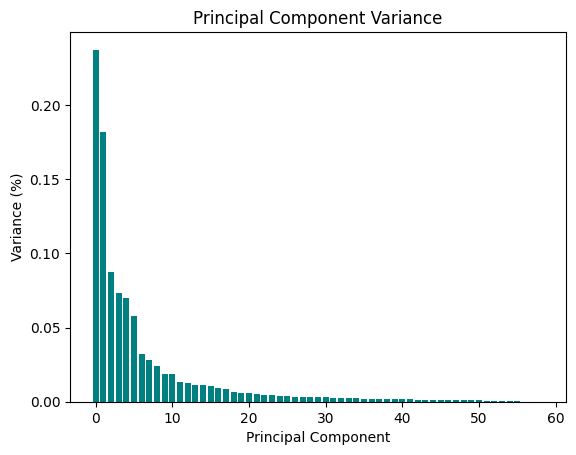

In [900]:
pca2 = PCA()
pca2.fit(pre_data)
# print()
d = {'Feature':pre_data.columns.values, 'PCA Variance Ratio':pca2.explained_variance_ratio_}
pca_info = pd.DataFrame(data=d)
l=[]

for z in range(1, len(pca_info['PCA Variance Ratio']) + 1):
  l.append(sum(pca_info['PCA Variance Ratio'].iloc[:z]))

pca_info['Sum PCA Variance'] = l
display(pca_info)

trained_pca = pca2.transform(pre_data)
var_ratio = pca_info['PCA Variance Ratio']

x=range(0, len(var_ratio))
plt.bar(x, var_ratio, color='teal')
plt.ylabel('Variance (%)')
plt.xlabel('Principal Component')
# plt.xticks(x, ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11'])
# plt.ylim([0,1])
plt.title('Principal Component Variance')
plt.show()

feat_cols = pca_info['Feature']
# print(feat_cols.iloc[:25])
data = pre_data[feat_cols.iloc[:25]]
data['match'] = pre_data['match']

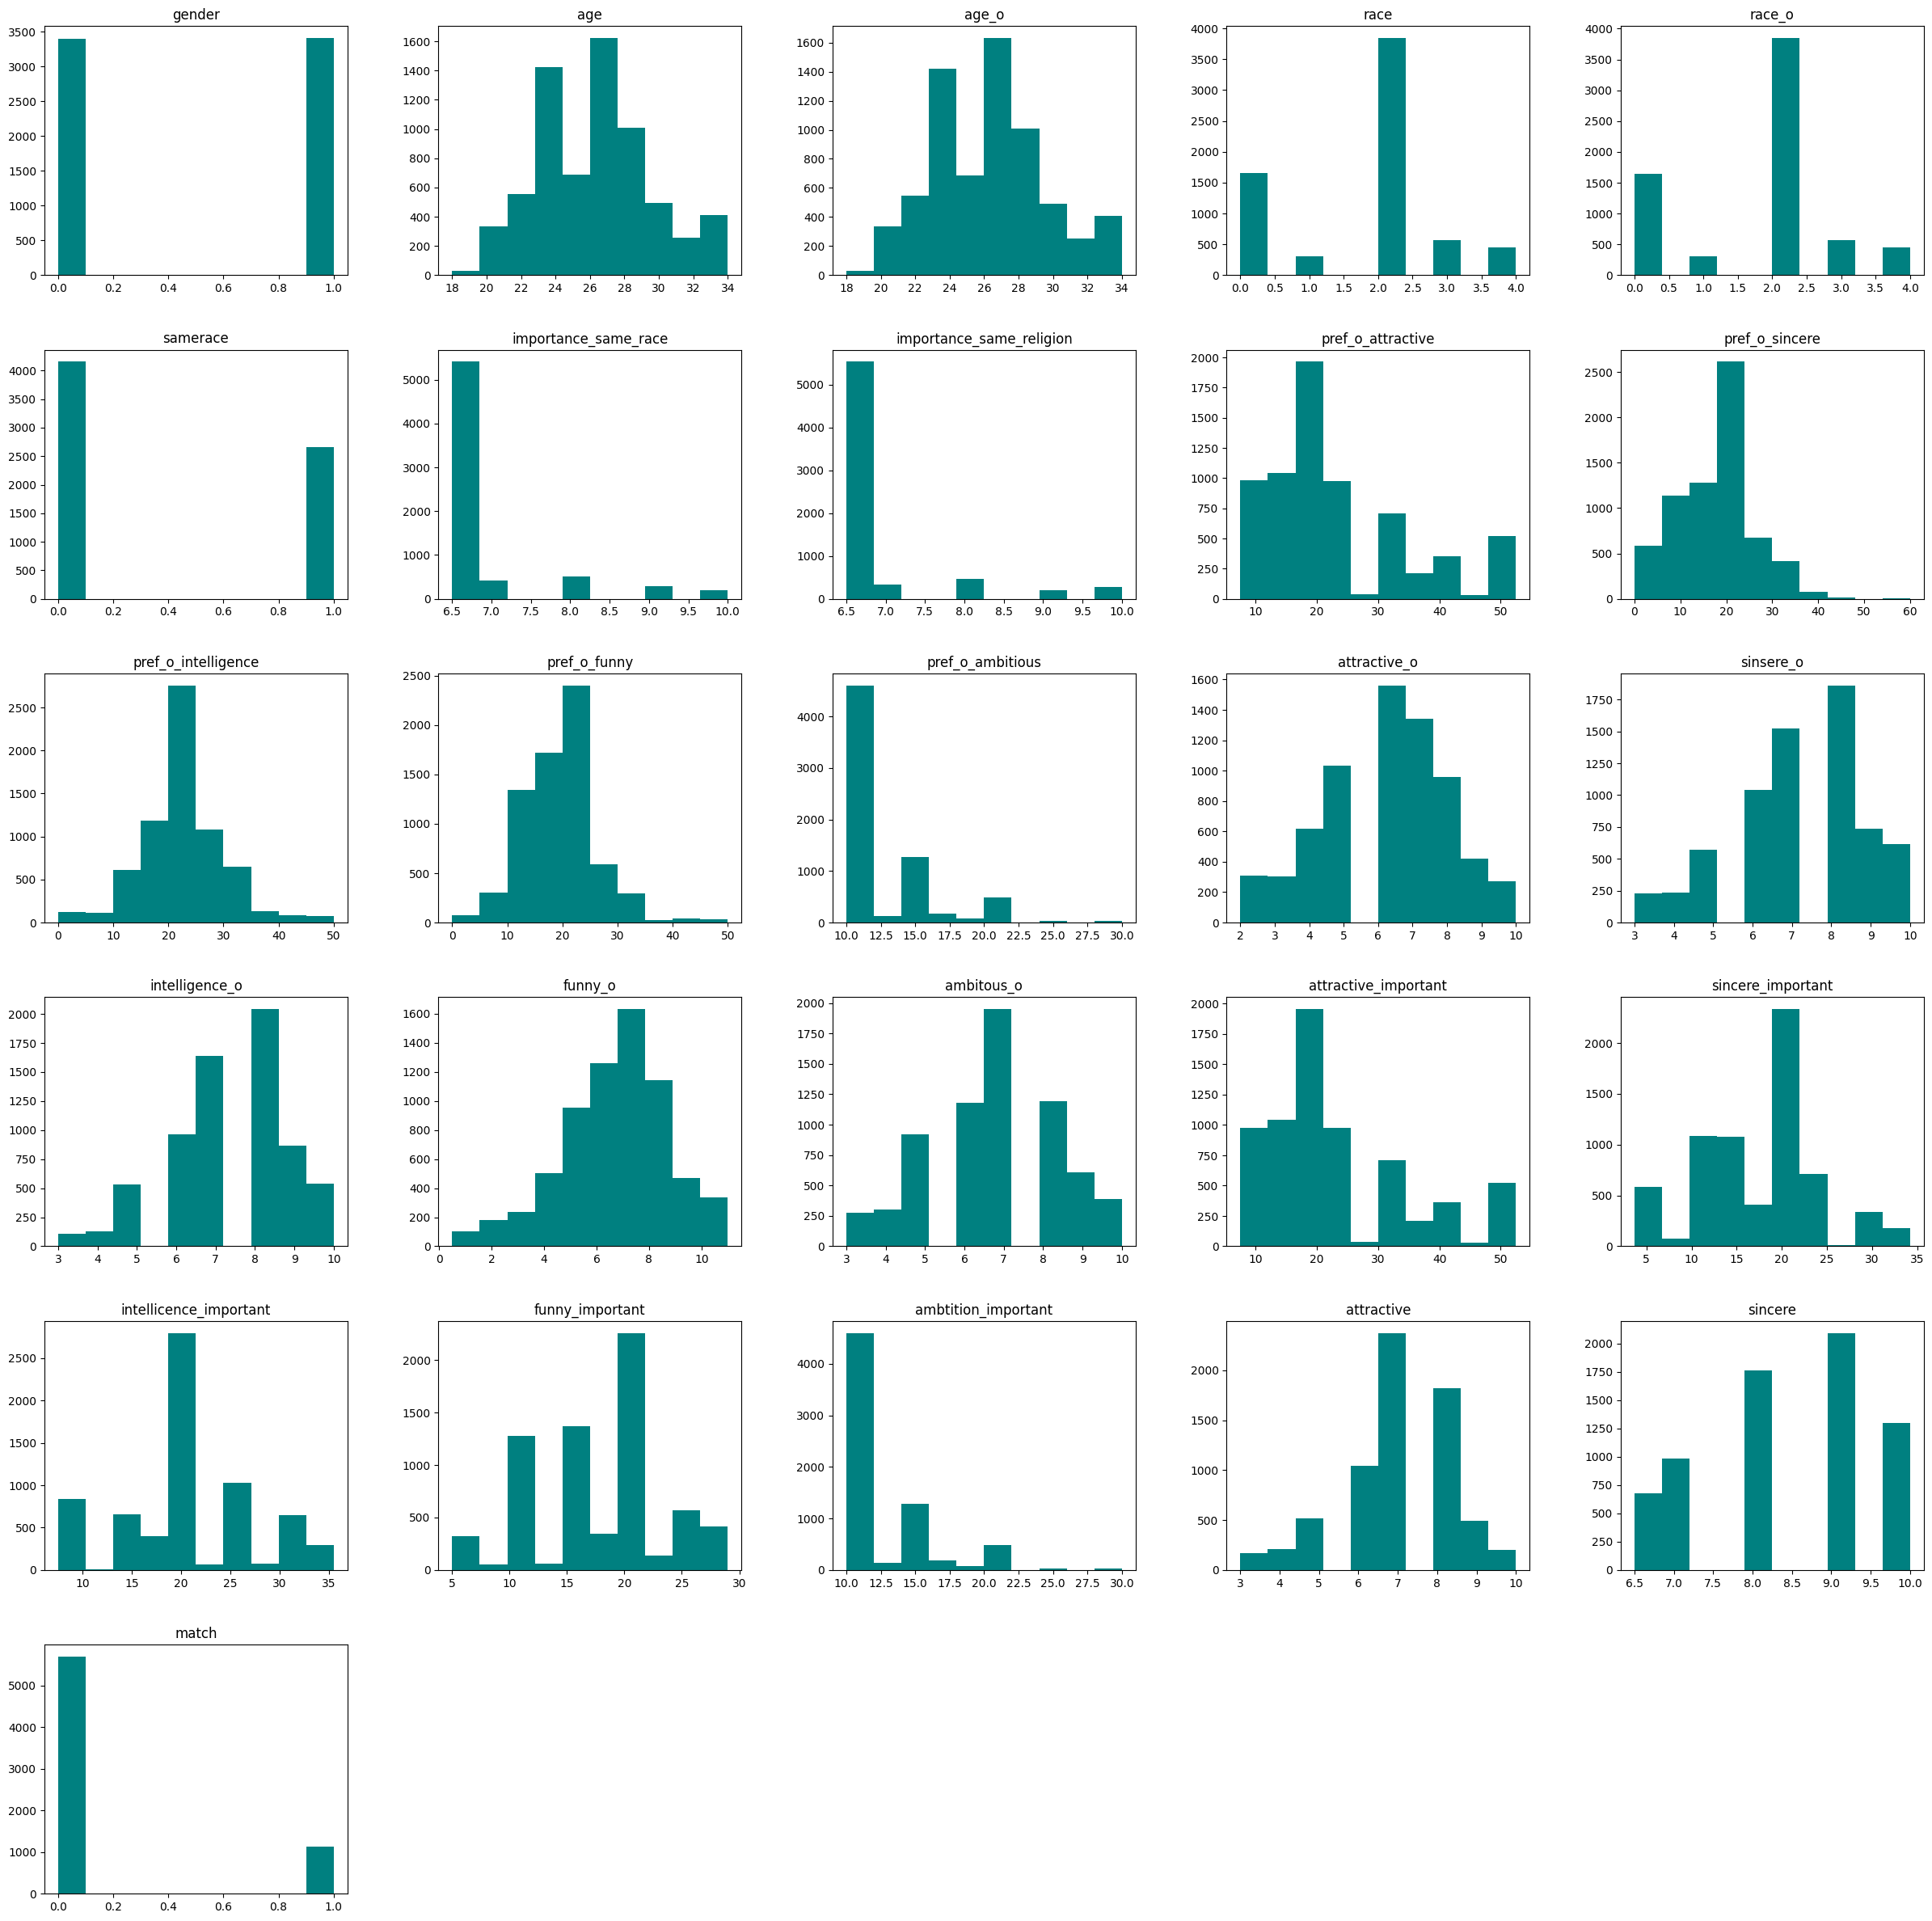

In [901]:
data.hist(figsize=(30,30), grid=False, color='teal')
plt.show()

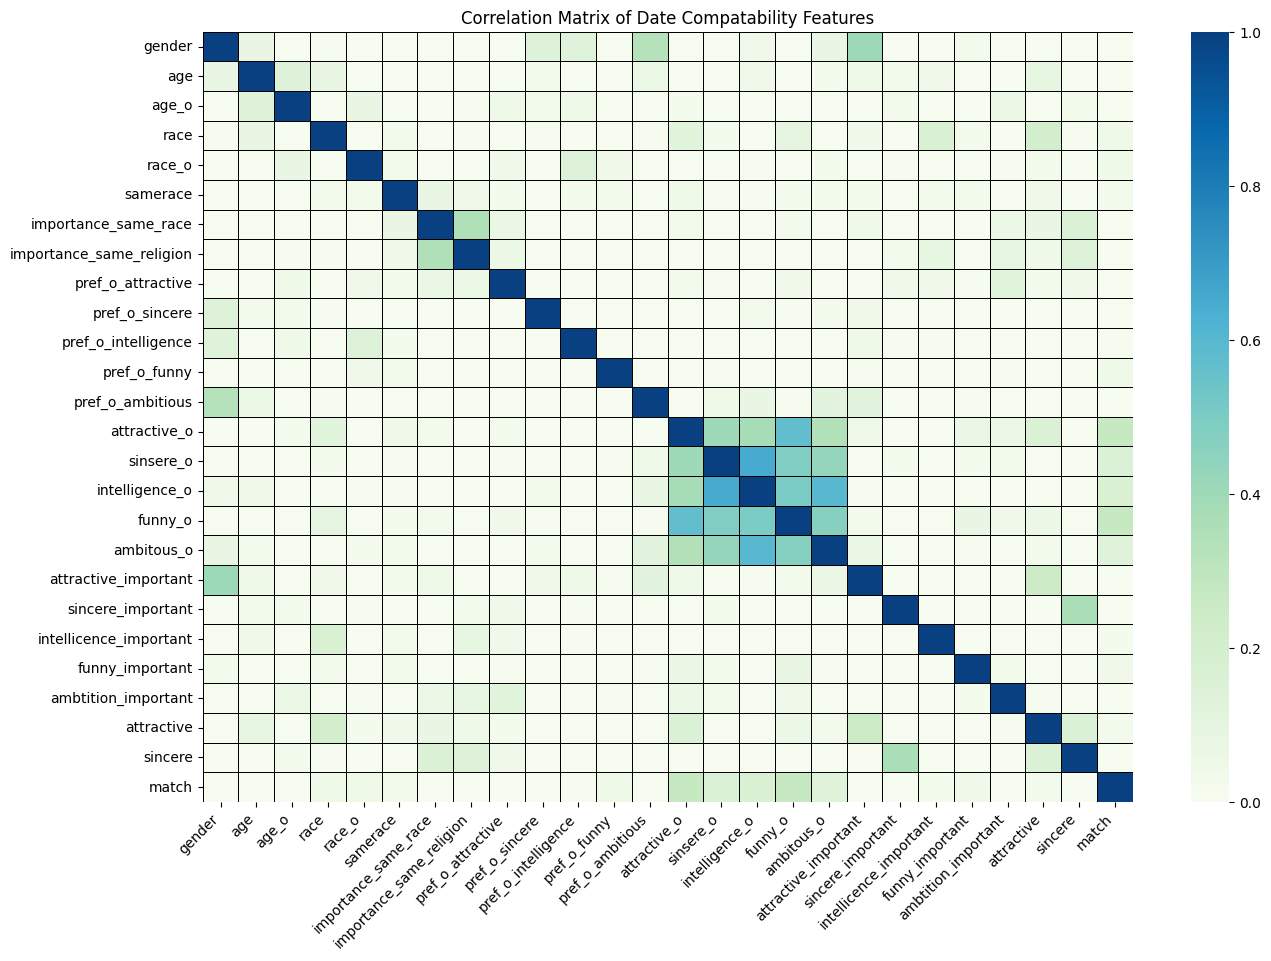

In [902]:
corr = round(data.corr(), 2)
mask = np.triu(np.ones_like(corr, dtype=bool))
fig = plt.figure(figsize=(15,10))
axes = fig.subplots()

sns.heatmap(corr, vmin=0, vmax=1, cmap='GnBu', linewidth=.5, linecolor='black')
plt.xticks(ha='right', rotation=45)
plt.title('Correlation Matrix of Date Compatability Features')
plt.show()

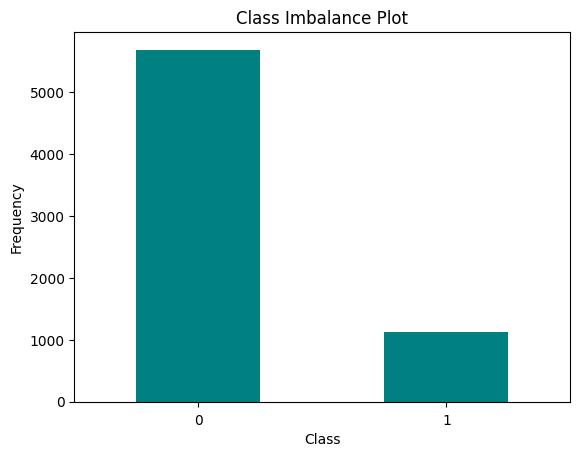

In [903]:
class_freq = data['match'].value_counts()

# plot bar chart
ax = class_freq.plot.bar(title='Class Imbalance Plot', color='teal')

# set x and y-axis labels
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')

# set x-axis tick labels to be horizontal and show 0 decimal places
ax.tick_params(axis='x', labelrotation=0)
ax.tick_params(axis='x', labelsize=10, labelcolor='black', pad=5)
ax.xaxis.set_major_formatter('{:.0f}'.format)


# display plot
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,15)) # W x H
axes = fig.subplots(4,6)
k=0
for i in range(4):
  for j in range(6):
    sns.boxplot(x=data['match'], 
                y = data.iloc[:,k], 
                data=data, 
                ax=axes[i,j], 
                palette='GnBu')
    axes[i,j].set_title(f'{data.columns[k]} Box Plot')
    k+=1

plt.tight_layout()
plt.show()

In [ ]:
match_col = data['match']
scaler = StandardScaler().set_output(transform='pandas')
data_feat = scaler.fit_transform(data.drop(['match'], axis=1))

# Models

In [ ]:
RANDOM = 1234

X = data_feat
y = match_col

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import warnings

from sklearn import tree

warnings.filterwarnings("ignore")


def pipe(X_train, X_test, y_train, y_test):
  dt_model = DecisionTreeClassifier(random_state=RANDOM)
  lr_model = LogisticRegression(random_state=RANDOM, C=1)
  knn_model = KNeighborsClassifier(n_neighbors=7)

  dt_model.fit(X_train,y_train)
  lr_model.fit(X_train,y_train)
  knn_model.fit(X_train,y_train)

  all_models={
      'Decision Tree' : dt_model,
      'Logistic Regression' : lr_model,
      'K Nearest Neighbors' : knn_model
  }

  return all_models

def class_report(name, model, X_test, y_test):
  
  y_pred = model.predict(X_test)

  report = classification_report(y_test, y_pred, output_dict=True)
  precision = report['weighted avg']['precision']
  recall = report['weighted avg']['recall']
  f1_score = report['weighted avg']['f1-score']
  accuracy = accuracy_score(y_test, y_pred)
  metrics = {'Precision':precision, 'Recall':recall, 'F1score':f1_score, 'Accuracy':accuracy}

  return metrics

def KfoldValidiation(X, y, split):
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  metrics_table = {'Precision':[], 'Recall':[], 'F1score':[], 'Accuracy':[]}
  model_names = [
      'Decision Tree',
      'Logistic Regression',
      'K Nearest Neighbors'
  ]

  model_metrics = {name:{'Precision':[], 'Recall':[], 'F1score':[], 'Accuracy':[]} for name in model_names}

  # Running each split
  for train_idx, test_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    all_models = pipe(X_train, X_test, y_train, y_test)    # Calling pipeline to fit each model
    
    for name,model in all_models.items():
      model_metric_fold = class_report(name, model, X_test, y_test)

      for key in model_metrics[name]:
        model_metrics[name][key].append(model_metric_fold[key])

  for name, model in model_metrics.items():
    df = pd.DataFrame.from_dict(model)
    print(f'{name} (split={split}):')
    display(df.round(3))
    print('\n')

  # tree_model = all_models['Decision Tree']
  # tree.plot_tree(tree_model, feature_names = [col for col in data.columns])

In [ ]:
for split in [.5,.3,.2]:
  print(f'Split: Test Size = {split} Train Size = {1-split}')
  X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X,y,random_state=RANDOM,test_size=split)
  KfoldValidiation(X_train_split, y_train_split, split)
  print('-'*50,'\n') 

In [ ]:
model_best_folds = {
      'Decision Tree': [2],
      'Logistic Regression': [2],
      'K Nearest Neighbors': [2]
     }

from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


def plot_roc_curve(X_test,y_test,name,model,fold,split):
  probas = model.predict_proba(X_test)
  fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {name} (Split={split}, Fold={fold})')
  plt.legend(loc=0)
  plt.show()


def get_best_fold(X, y, best_fold):
  kf = KFold(n_splits=10, shuffle=True, random_state=42)

  train_idx, test_idx = list(kf.split(X))[best_fold-1]
  X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
  X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

  return X_train, X_test, y_train, y_test

train_sizes = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
def plot_learning_curve(X,y,name,model,fold,split,ts=train_sizes):
  train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes=ts, scoring='neg_mean_squared_error')

  train_scores = -train_scores
  test_scores = -test_scores
  train_mean = np.mean(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)

  fig, ax = plt.subplots(figsize=(7,7))
  
  fig.suptitle(f'{name} (Split={split}, Fold={fold})')

  ax.plot(train_sizes, train_mean, color='blue', label='training error')
  ax.plot(train_sizes, test_mean, color='red', label='validation error')

  last_x = train_sizes[-1]
  last_y = test_mean[-1]
  ax.annotate(f'{last_y:.2f}', xy=(last_x, last_y), xytext=(last_x, last_y),
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

  last_x = train_sizes[-1]
  last_y = train_mean[-1]
  ax.annotate(f'{last_y:.2f}', xy=(last_x, last_y), xytext=(last_x, last_y),
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

  
  ax.set_xlabel('Num of Training Samples')
  ax.set_ylabel('Error')
  ax.set_title('Learning Curve')

  for side in ax.spines:
    ax.spines[side].set_color('black')
    ax.spines[side].set_linewidth(1)

  ax.grid(False)
  ax.set_facecolor('white')
  ax.legend(loc=0)

  if name == 'Decision Tree':
    ax.set_ylim(0,0.30)
  else:
    ax.set_ylim(0.12,0.20)

  plt.plot()
  print('\n')
  

def display_confusion_matrix(X_test,y_true,name,model,fold,split):
    if name == 'Linear Regression':
      print('no confusion matrix for', name)
    else:
      y_pred = model.predict(X_test)
      print(y_true.value_counts())
      cf_matrix = confusion_matrix(y_pred,y_true)

      labels = [[0,0],[0,0]]

      for i in range(2):
        for j in range(2):
            x = cf_matrix[i][j]
            x = f'{x} ({x/sum(cf_matrix.flatten()): .1%})'
            labels[i][j] = x

      sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='')
      plt.title(f'{name} Confusion Matrix')
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.show()
      print('\n')

In [ ]:
split = .3
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X,y,random_state=RANDOM,test_size=split)
X_train_best, X_test_best, y_train_best, y_test_best = get_best_fold(X_train_split, y_train_split,2) 

dt1_model = DecisionTreeClassifier(random_state=RANDOM, criterion='entropy', max_depth=4)
dt2_model = DecisionTreeClassifier(random_state=RANDOM, criterion='gini', max_depth=4)

dt1_model.fit(X_train_best,y_train_best)
dt2_model.fit(X_train_best,y_train_best)

ts = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fig, ax = plt.subplots(figsize=(7,7))

#lr_model
train_sizes, train_scores, test_scores = learning_curve(dt1_model, X_train_best,y_train_best, train_sizes=ts, scoring='neg_mean_squared_error')

train_scores = -train_scores
test_scores = -test_scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

ax.plot(train_sizes, test_mean-train_mean, label='Entropy')


#knn_model
train_sizes, train_scores, test_scores = learning_curve(dt2_model, X_train_best,y_train_best, train_sizes=ts, scoring='neg_mean_squared_error')

train_scores = -train_scores
test_scores = -test_scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

ax.plot(train_sizes, test_mean-train_mean, label='Gini')

#---


ax.set_xlabel('Num of Training Samples')
ax.set_ylabel('Error')
ax.set_title('Generalization Error (Depth = 4)')

for side in ax.spines:
  ax.spines[side].set_color('black')
  ax.spines[side].set_linewidth(1)

ax.grid(False)
ax.set_facecolor('white')
ax.legend(loc=0)
plt.plot()

In [ ]:
for i,split in enumerate([.3]):
  X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X,y,random_state=RANDOM,test_size=split)

  for name, folds in model_best_folds.items():
    best_model_fold = folds[i]
    X_train_best, X_test_best, y_train_best, y_test_best = get_best_fold(X_train_split, y_train_split,best_model_fold) 
    
    all_models = pipe(X_train_best, X_test_best, y_train_best, y_test_best)
    model = all_models[name]

    # plot_learning_curve(X_train_best,y_train_best,name,model,best_model_fold,split)
    display_confusion_matrix(X_test_best,y_test_best,name,model,best_model_fold,split)
    #y_pred = model.predict(X_test_best)
    #print(confusion_matrix(y_pred,y_test_best))
 

In [ ]:
split = .3
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X,y,random_state=RANDOM,test_size=split)

X_train_best, X_test_best, y_train_best, y_test_best = get_best_fold(X_train_split, y_train_split,2) 

dt_model = DecisionTreeClassifier(random_state=RANDOM, criterion='entropy')

dt_model.fit(X_train_best,y_train_best)

display_confusion_matrix(X_test_best,y_test_best,"Decision Tree Classifier (entropy)",dt_model,2,split)


# #plotting roc
# probas = dt_model.predict_proba(X_test_best)
# fpr, tpr, thresholds = roc_curve(y_test_best, probas[:, 1])
# roc_auc = auc(fpr, tpr)

# plt.plot(fpr, tpr, label=f'AUC = {roc_auc: .2f}, depth = {i}')
# #---

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title(f'Logistic Regression ROC Curve (Entropy)')
# plt.legend()
# plt.show()

In [ ]:
split = .3
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X,y,random_state=RANDOM,test_size=split)
X_train_best, X_test_best, y_train_best, y_test_best = get_best_fold(X_train_split, y_train_split,2) 


fig, ax = plt.subplots(figsize=(7,7))

for i in range(5,11):

  knn_model = KNeighborsClassifier(n_neighbors=i)
  knn_model.fit(X_train_best,y_train_best)

  #plotting roc
  probas = knn_model.predict_proba(X_test_best)
  fpr, tpr, thresholds = roc_curve(y_test_best, probas[:, 1])
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, label=f'AUC = {roc_auc: .2f}, k = {i}')
  #---



plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{name} ROC Curve')
plt.show()